## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree

## Data Preprocessing

First, we read in the dataset.

In [2]:
#| label: dataset-preview
df = pd.read_csv("../data/wind.csv")
df.head(5)

,id,lat,long,state,farm_type,wind_speed,lcoe,capacity,capacity_factor,available_wind_power,available_energy,generated_energy,cost
0,0,25.896492,-97.460358,Texas,onshore,7.46,31,2,0.433,1.997163,17495.14630,7575.398348,4.696747e+06
1,1,26.032654,-97.738098,Texas,onshore,7.45,31,10,0.414,9.945710,87124.42376,36069.511440,2.236310e+07
2,2,26.059063,-97.208252,Texas,onshore,8.18,31,2,0.506,2.633037,23065.40088,11671.092850,7.236078e+06
3,3,26.078449,-98.073364,Texas,onshore,7.17,31,16,0.363,14.185493,124264.92160,45108.166540,2.796706e+07
4,4,26.143227,-98.311340,Texas,onshore,7.06,31,16,0.358,13.542570,118632.91080,42470.582050,2.633176e+07


Now, we must shuffle the datasets to reduce bias.

In [3]:
#| label: shuffled-dataset-preview

df = df.sample(frac=1)
df.head(5)

,id,lat,long,state,farm_type,wind_speed,lcoe,capacity,capacity_factor,available_wind_power,available_energy,generated_energy,cost
104321,104321,47.115517,-106.994720,Montana,onshore,8.08,31,16,0.439,20.301170,177838.24560,78070.98984,48404013.70
44108,44108,40.504593,-87.896454,Illinois,onshore,7.16,36,16,0.374,14.126223,123745.70950,46280.89535,33322244.65
19515,19515,36.364742,-88.897675,Tennessee,onshore,6.74,45,16,0.387,11.783293,103221.64420,39946.77632,35952098.69
4940,4940,32.670708,-102.887939,Texas,onshore,7.34,31,16,0.411,15.218616,133315.07550,54792.49602,33971347.53
70776,70776,39.942379,-122.230392,California,onshore,6.11,47,16,0.338,8.778304,76897.94144,25991.50421,24432013.95


Looking at each dataset, we can identify which variables we want to use for our models.

In [4]:
X = df.loc[:, ['lat','long','capacity']]
y = df.loc[:, ['generated_energy','cost']]

Now we split into training and testing sets, reserving about 80% for training and 20% for testing.

In [5]:
X_train = X[:100000]
X_test = X[100000:]
y_train = y[:100000]
y_test = y[100000:]

Models typically perform better when input values are within a certain range, like [-1, 1] for example. We scale the data points appropriately.

In [6]:
#| label: scaled-data

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[ 1.50475958, -0.69192413,  0.51463162],
       [-0.00765112,  0.91790859,  0.51463162],
       [-0.95474337,  0.83351358,  0.51463162],
       ...,
       [ 0.20099693, -0.87590282, -0.07786604],
       [-0.09467121, -0.45629192,  0.51463162],
       [ 1.00200959,  0.73976282,  0.51463162]])

## Training the Models

Now that the data is pre-processed accordingly, the models can be trained and fit.

In [7]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)

RandomForestRegressor()

With a trained model, predictions can now be made.

In [8]:
#| label: prediction-comparisons

display = y_test.reset_index()
preds = reg.predict(X_test)
print("Predictions")
print("----------------------")
for i in range(3):
    print(f"predicted energy: {preds[i][0]:.2f}\tactual energy: {display.at[i, 'generated_energy']:.2f}\tpredicted cost: {preds[i][1]:.2f}\tactual cost: {display.at[i, 'cost']:.2f}")

Predictions
----------------------
predicted energy: 39496.22	actual energy: 40307.25	predicted cost: 23697732.20	actual cost: 24184348.66
predicted energy: 102419.64	actual energy: 101556.00	predicted cost: 61451784.90	actual cost: 60933600.27
predicted energy: 49848.14	actual energy: 128958.46	predicted cost: 32899772.22	actual cost: 85112586.37


## Testing and Analyzing the Models

This section contains metrics gathering and other figures that visualize the models and its results.

### Metrics

#### Scores and Error Values

The score being recored are the R2 score, Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

In [9]:
#| label: metrics

r2 = metrics.r2_score(y_test, preds, multioutput="raw_values")
rmse = metrics.root_mean_squared_error(y_test, preds, multioutput="raw_values")
mape = metrics.mean_absolute_percentage_error(y_test, preds, multioutput="raw_values")

print("Metric\tScore")
print("-----------------------")
print(f"r2\t{r2}\nrmse\t{rmse}\nmape\t{mape}")

Metric	Score
-----------------------
r2	[0.9223821  0.89367722]
rmse	[   8843.51723011 6421746.41274378]
mape	[0.12902421 0.1288721 ]


#### Feature Importances

Feature importances give insights into the features that each decision tree in the random forest use to split most often. Results are portrayed in percentages.

In [10]:
#| label: feature-importances

features = ['lat','long','capacity',]

importances = reg.feature_importances_
indices = np.argsort(importances)

print("Importances")
print('----------------------')
for i in indices:
    print(f"{features[i]}: {importances[i]*100}")

Importances
----------------------
capacity: 20.230960634451716
lat: 35.095811124953094
long: 44.67322824059519


#### K-Fold Cross Validation

This cross validation splits up the dataset into 10 unique folds, which are then used to test a model. The model is then scored using the same metrics outlined above: R2, RMSE, MAPE. This ensures the scoring is rigorous, and the *entire* dataset is used.

In [14]:
#| label: k-fold-cross-validation-table

kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf_cv_scores = cross_validate(reg, X, y, cv=kf, scoring={"r2":metrics.make_scorer(score_func=metrics.r2_score),
 "rmse":metrics.make_scorer(score_func=metrics.root_mean_squared_error),
 "mape":metrics.make_scorer(score_func=metrics.mean_absolute_percentage_error)})
kf_cv_df = pd.DataFrame.from_dict(kf_cv_scores)
means = kf_cv_df.mean()
print("10-Fold Cross Validation Scores")
print("----------------------------------------------------")
print(f"R2 Average: {means.iloc[2]}")
print(f"RMSE Average: {means.iloc[3]}")
print(f"MAPE Average: {means.iloc[4]}")
kf_cv_df

10-Fold Cross Validation Scores
----------------------------------------------------
R2 Average: 0.9109908237527048
RMSE Average: 3181739.2057383326
MAPE Average: 0.13390596472645255


,fit_time,score_time,test_r2,test_rmse,test_mape
0,35.631838,0.412091,0.908636,3.244508e+06,0.126463
1,35.085633,0.407737,0.909902,3.194235e+06,0.134273
2,34.784758,0.409132,0.912724,3.128678e+06,0.129694
3,34.819360,0.401673,0.908216,3.253428e+06,0.126229
4,34.879103,0.404808,0.907344,3.241619e+06,0.137367
5,34.481580,0.417363,0.915569,3.113150e+06,0.137573
6,35.357341,0.434344,0.908085,3.232867e+06,0.148030
7,37.669082,0.456003,0.915380,3.138264e+06,0.137533
8,37.000147,0.439912,0.913334,3.138594e+06,0.128061
9,34.930129,0.409387,0.910719,3.132047e+06,0.133837


### Graphs

Graphs of the Random Forest model fits on each of the input features, for each target.

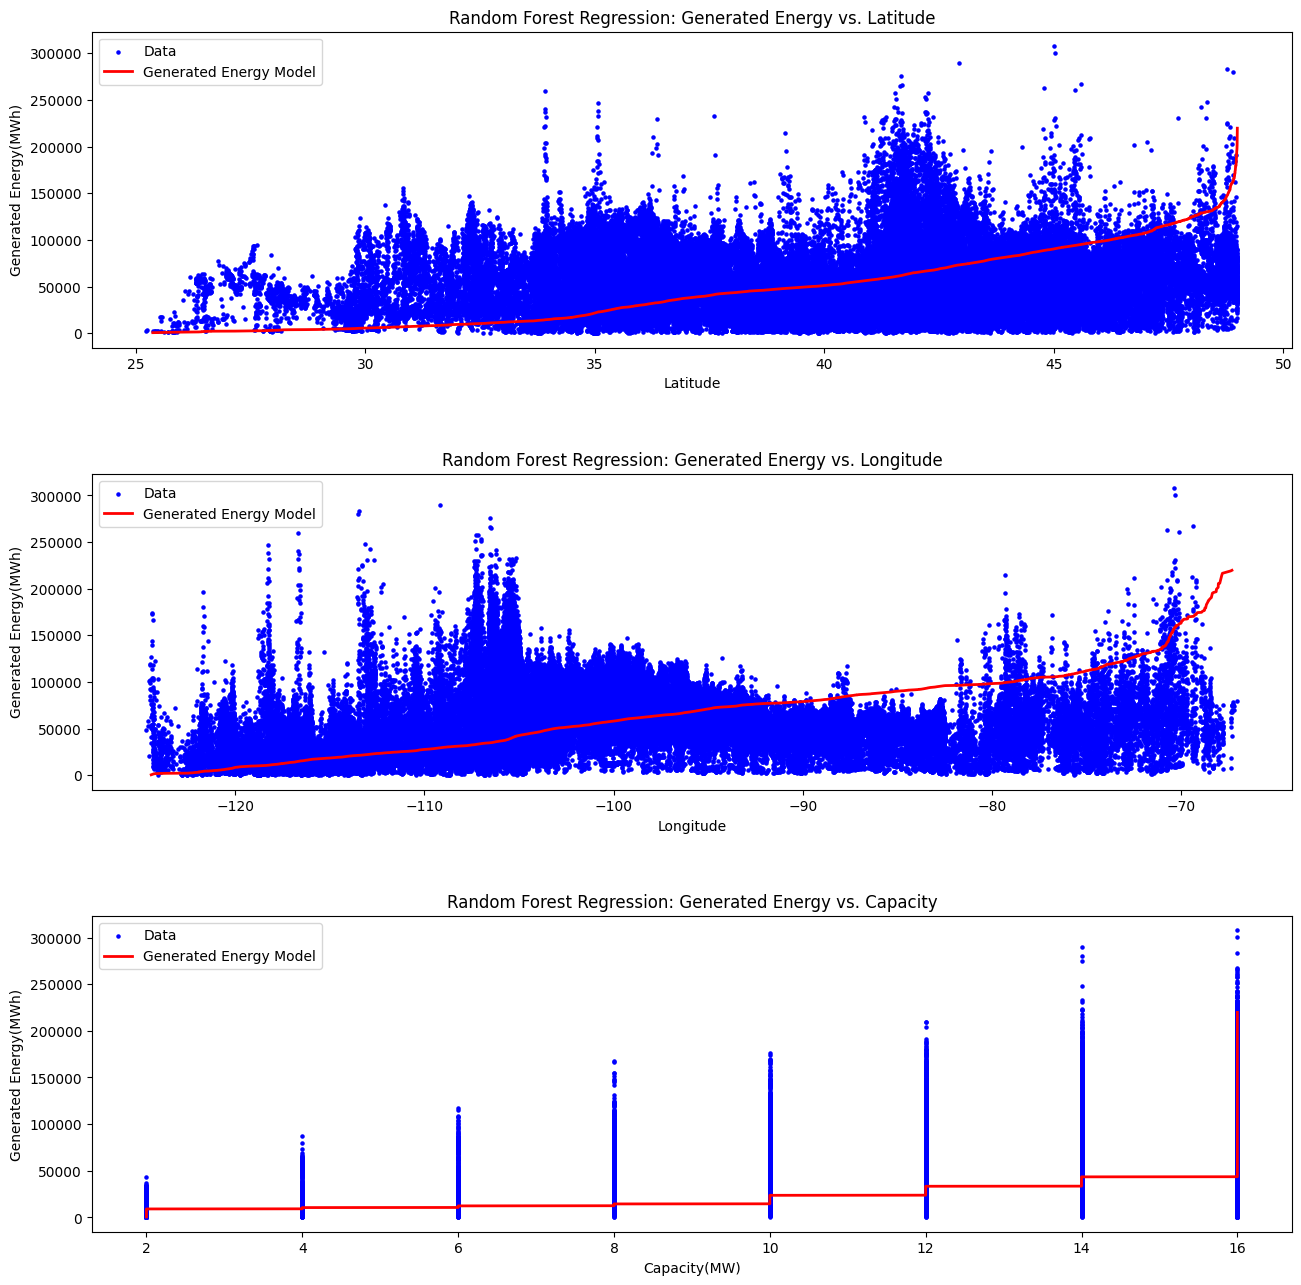

In [14]:
#| label: fig-generated-energy-vs-input-features

plot_lat_x = X[100000:].loc[:,['lat']].sort_values(by=['lat'])
plot_long_x = X[100000:].loc[:,['long']].sort_values(by=['long'])
plot_cap_x = X[100000:].loc[:,['capacity']].sort_values(by=['capacity'])
plot_energy_y = pd.DataFrame(preds).loc[:,[0]].sort_values(by=[0])

figure, axis = plt.subplots(3)

figure.set_size_inches(15,15)

axis[0].scatter(X.loc[:,["lat"]], y.loc[:,['generated_energy']], color='blue', label='Data', s=5)
axis[0].plot(plot_lat_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[0].set_xlabel("Latitude")
axis[0].set_ylabel("Generated Energy(MWh)")
axis[0].set_title("Random Forest Regression: Generated Energy vs. Latitude")
axis[0].legend()

axis[1].scatter(X.loc[:,["long"]], y.loc[:,['generated_energy']], color='blue', label='Data', s=5)
axis[1].plot(plot_long_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[1].set_xlabel("Longitude")
axis[1].set_ylabel("Generated Energy(MWh)")
axis[1].set_title("Random Forest Regression: Generated Energy vs. Longitude")
axis[1].legend()

axis[2].scatter(X.loc[:,["capacity"]], y.loc[:,['generated_energy']], color='blue', label='Data', s=5)
axis[2].plot(plot_cap_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[2].set_xlabel("Capacity(MW)")
axis[2].set_ylabel("Generated Energy(MWh)")
axis[2].set_title("Random Forest Regression: Generated Energy vs. Capacity")
axis[2].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.4, 
                    hspace=.4)

plt.show()

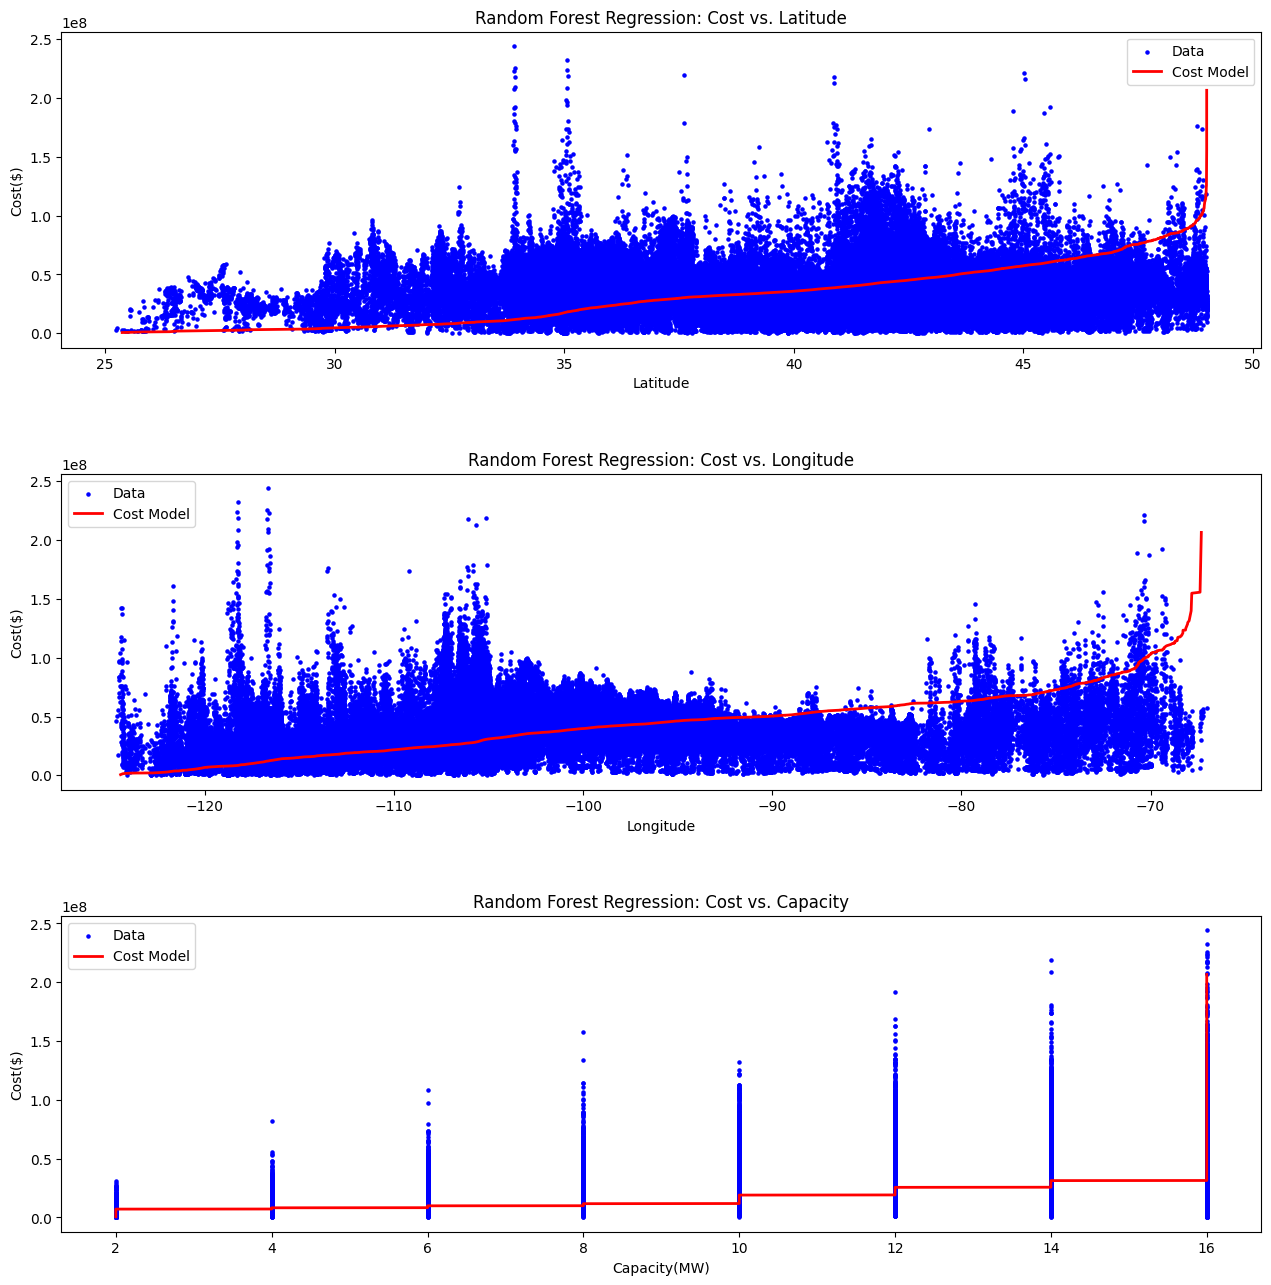

In [15]:
#| label: fig-cost-vs-input-features

plot_cost_y = pd.DataFrame(preds).loc[:,[1]].sort_values(by=[1])

figure, axis = plt.subplots(3)

figure.set_size_inches(15,15)

axis[0].scatter(X.loc[:,["lat"]], y.loc[:,['cost']], color='blue', label='Data', s=5)
axis[0].plot(plot_lat_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[0].set_xlabel("Latitude")
axis[0].set_ylabel("Cost($)")
axis[0].set_title("Random Forest Regression: Cost vs. Latitude")
axis[0].legend()

axis[1].scatter(X.loc[:,["long"]], y.loc[:,['cost']], color='blue', label='Data', s=5)
axis[1].plot(plot_long_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[1].set_xlabel("Longitude")
axis[1].set_ylabel("Cost($)")
axis[1].set_title("Random Forest Regression: Cost vs. Longitude")
axis[1].legend()

axis[2].scatter(X.loc[:,["capacity"]], y.loc[:,['cost']], color='blue', label='Data', s=5)
axis[2].plot(plot_cap_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[2].set_xlabel("Capacity(MW)")
axis[2].set_ylabel("Cost($)")
axis[2].set_title("Random Forest Regression: Cost vs. Capacity")
axis[2].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.4, 
                    hspace=.4)

plt.show()

A graph of the feature importances. This helps to visualize the magnitude of importance of each feature, and compare their impact against one another.

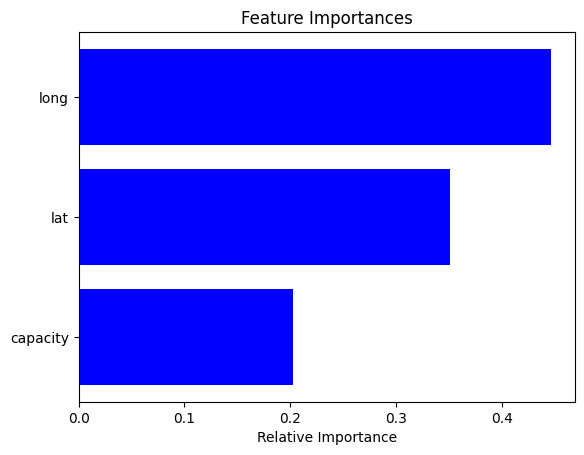

In [13]:
#| label: fig-feature-importances

plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

A graph of one of the decision trees in the random forest. This displays the decision making process the model takes to arive at predictions.

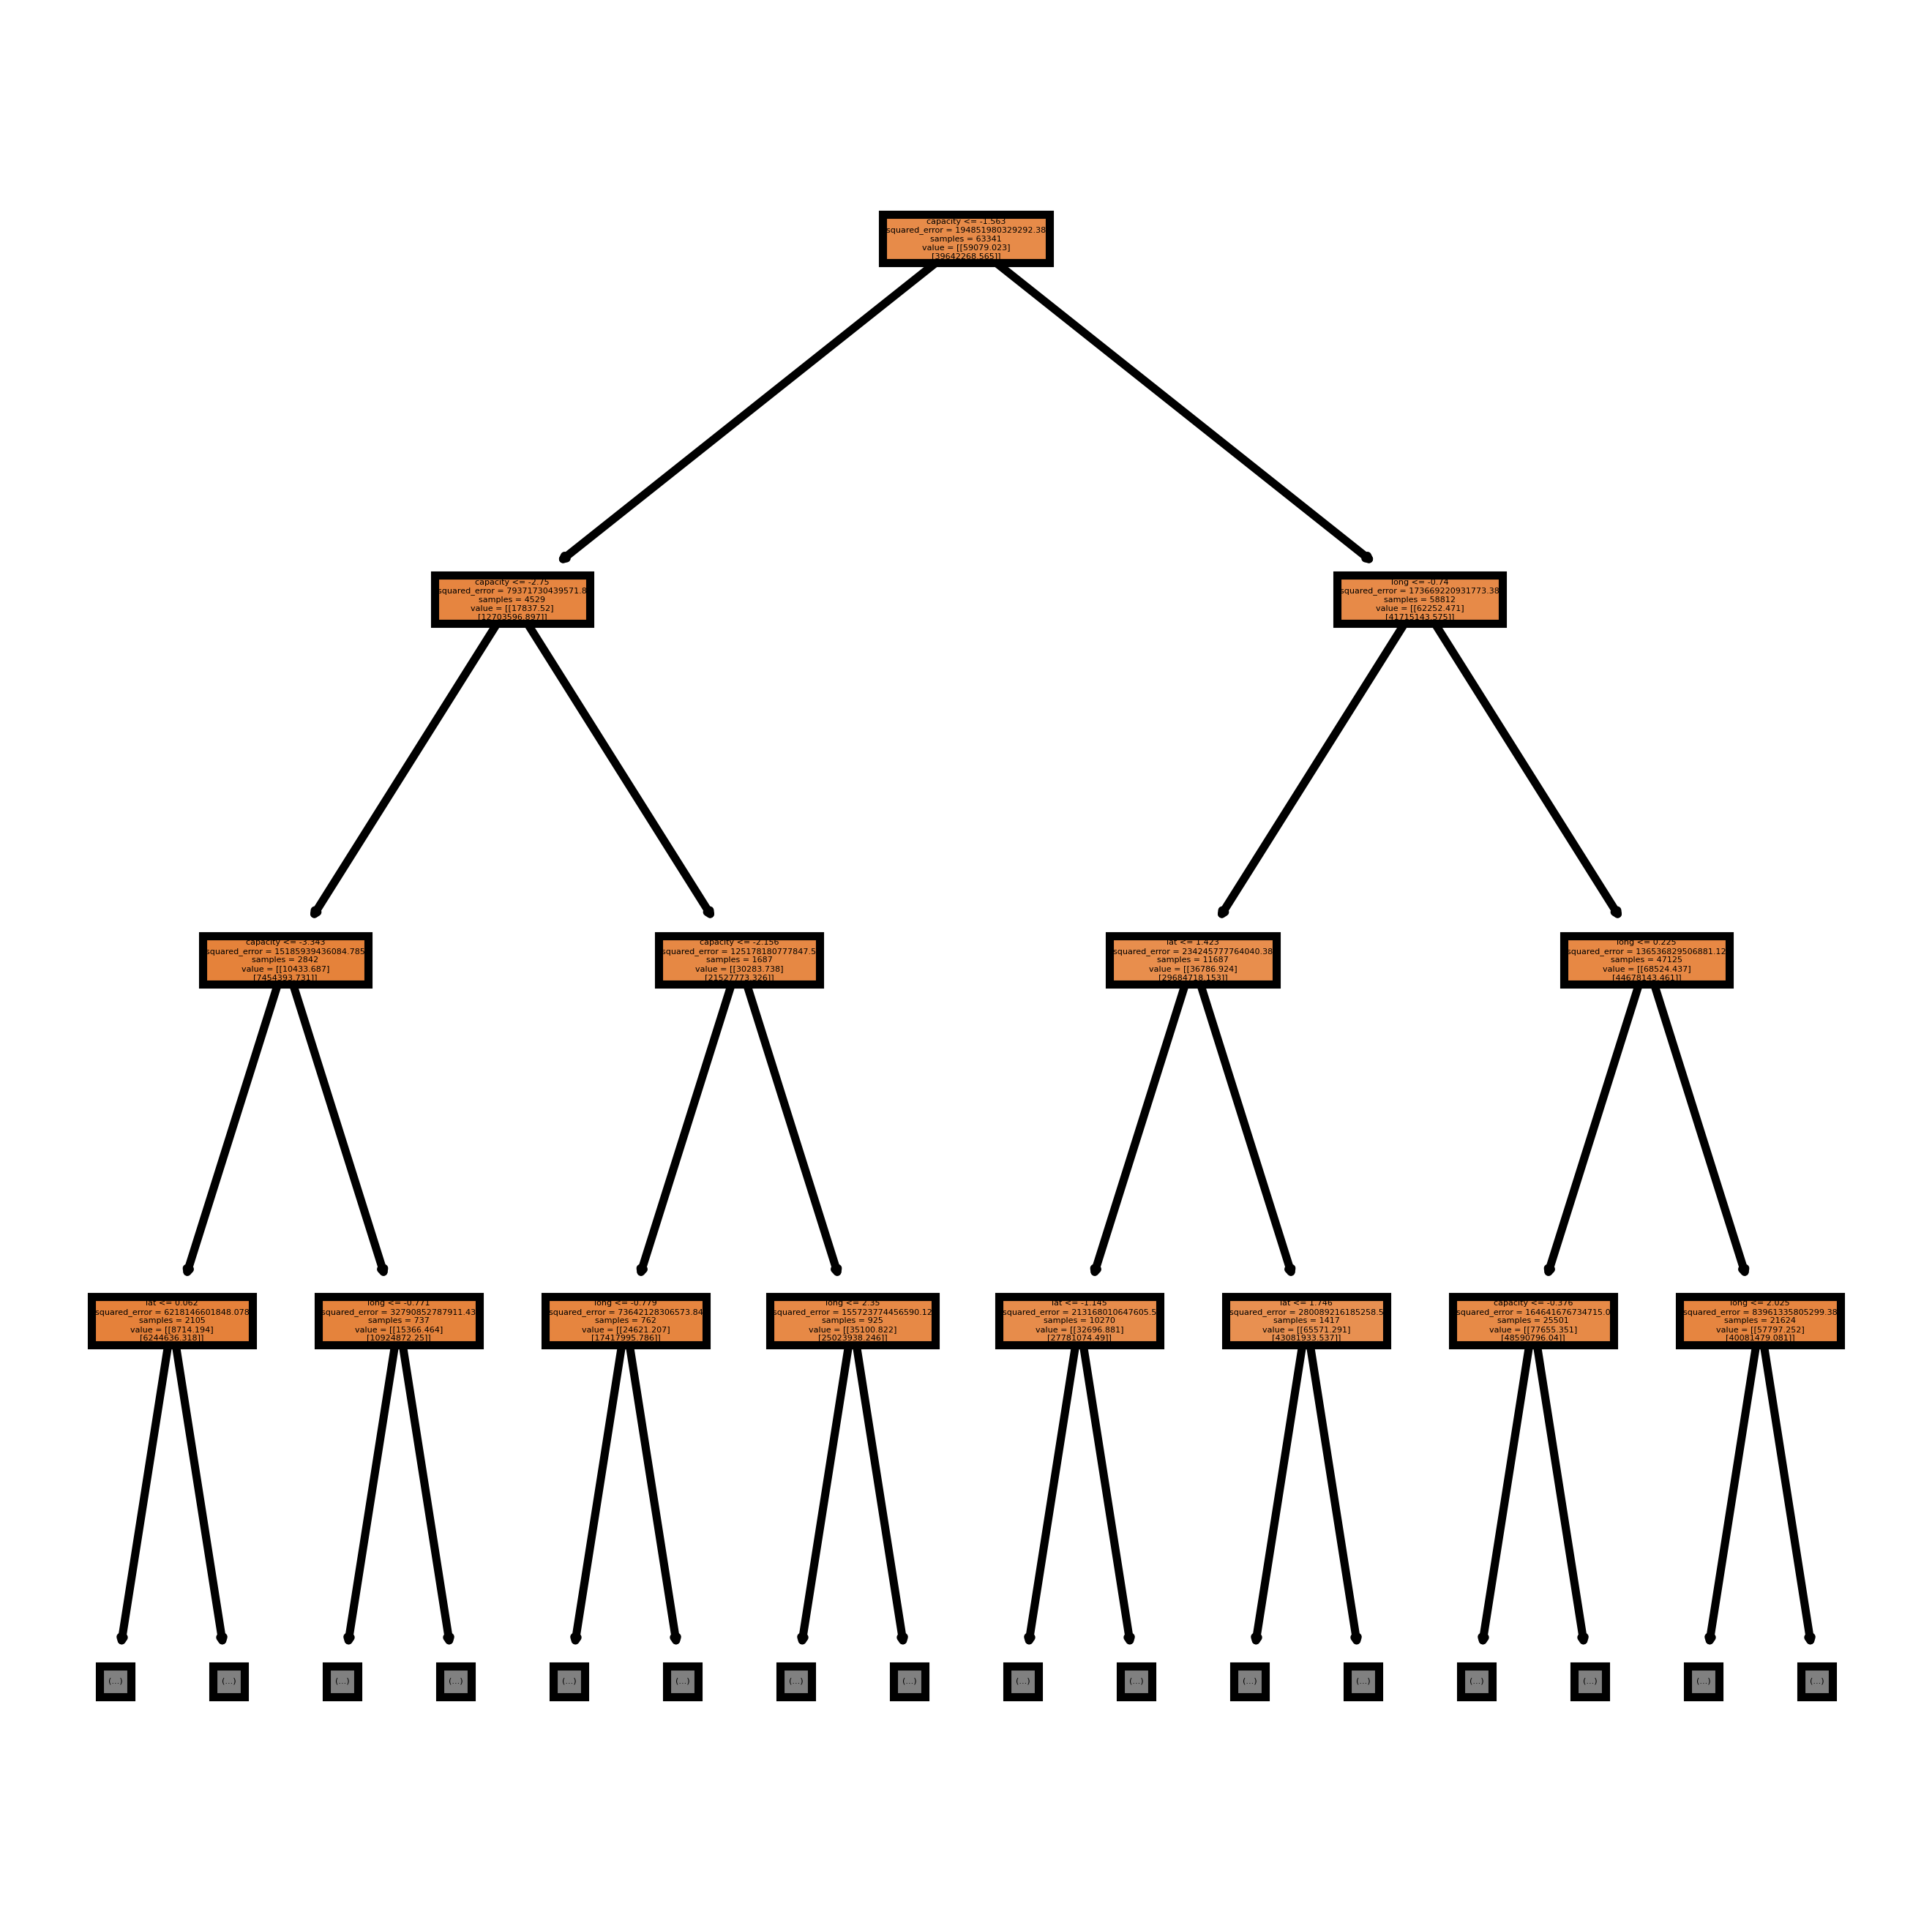

In [15]:
#| label: fig-decision-tree

fn = ['lat','long','capacity']
cn = ['generated_energy','cost']
plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=800)
tree.plot_tree(reg.estimators_[0],feature_names=fn,class_names=cn,filled=True, max_depth=3)
plt.show()